# **Dependencies**

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
!pip uninstall transformer
!pip install git+https://github.com/huggingface/transformers
!pip install mamba-ssm[causal-conv1d]==2.2.4 --no-build-isolation
!pip install rouge-score
!pip install grad-cam

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-flo_ray9
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-flo_ray9
  Resolved https://github.com/huggingface/transformers to commit 5af248b3e3bf854e884c53f05b17ed1e0ca2ed24
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.2/562.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 65.4 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.57.0.dev0-py3-none-any.whl size=12708903 sha256=2cc9218d49d86cfca806374c198d89a303c4ed0cb7b6ed1123fd21afbb0ec8a3
  Stored in directory: /tmp/pip-ephem-wheel-cache-lazjgzfr/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Found existing i

# **Data Preprocessing , DataSet and DataLoaders**

In [3]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision import models
import math
from torch.cuda.amp import GradScaler, autocast
from transformers import get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
import re
from transformers import BitsAndBytesConfig
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

2025-09-15 19:01:05.002170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757962865.223564      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757962865.286819      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# **Configuration**

In [5]:
XML_REPORTS_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_reports/ecgen-radiology/"
IMAGES_PATH      = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/"

# Model & Training Params
TOKENIZER_NAME   = "gpt2"
BATCH_SIZE       = 4
MAX_SEQ_LENGTH   = 512
IMAGE_SIZE       = 224

# Data Split Params (R2Gen-style ratios commonly used in IU-Xray literature)
TRAIN_RATIO      = 0.80  # train
VALID_RATIO      = 0.10  # val
TEST_RATIO       = 0.10  # test
RANDOM_STATE     = 42
RAMDOM_SEED      = 9223
assert abs(TRAIN_RATIO + VALID_RATIO + TEST_RATIO - 1.0) < 1e-6, "Ratios must sum to 1."

In [6]:
import pandas as pd

CHEXPERT_CSV_PATH = "/kaggle/input/chex-lables-iu-dataset/chexpert_labels.csv"
labels_df = pd.read_csv(CHEXPERT_CSV_PATH)

def get_study_num_from_pid(pid):
    return pid.split('_')[-1]

labels_df['study_num'] = labels_df['study_id'].apply(lambda x: re.search(r'(\d+)', str(x)).group(1) if re.search(r'(\d+)', str(x)) else None)
labels_df.set_index('study_num', inplace=True)

# List of the 14 pathology columns
CHEXPERT_LABELS = [
    'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
    'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
    'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'No Finding'
]

# Create a lookup dictionary: { 'study_num': [0.0, 1.0, 0.0, ...], ... }
# We'll fill NaNs with 0 (assuming NaN means not present)
label_lookup = labels_df[CHEXPERT_LABELS].fillna(0.0).to_dict(orient='index')
# Convert the inner dicts to lists for easier processing
for key, value_dict in label_lookup.items():
    label_lookup[key] = [value_dict[label] for label in CHEXPERT_LABELS]

print(f"Loaded {len(label_lookup)} studies with CheXpert labels.")

Loaded 3927 studies with CheXpert labels.


In [7]:
# 2) Cleaning, patient-id extraction, manifest builder (multi-view + patient_id)

import re

_punct_to_remove = re.compile(r'[?*;!%^&_+():\[\]{}"\\/]+')
_multiple_spaces = re.compile(r'\s{2,}')
_multiple_periods = re.compile(r'\.{2,}')

def clean_text(text):
    if not text or not isinstance(text, str):
        return ""

    text = text.lower().strip()
    text = text.replace('xxxx', '') # Remove placeholder
    text = text.replace('\n', ' ').replace('\r', ' ') # Normalize whitespace

    # Keep commas and periods, but remove other punctuation
    text = _punct_to_remove.sub('', text)
    
    # Standardize spacing around periods and commas
    text = re.sub(r'\s*([,.])\s*', r' \1 ', text)
    
    # Collapse multiple spaces and periods
    text = _multiple_spaces.sub(' ', text)
    text = _multiple_periods.sub(' . ', text) # Ensure space around periods

    return text.strip()

def extract_patient_id_from_xml(xml_path):
    """
    Derive a stable patient_id for IU X-ray:
    - Prefer deriving from the first parentImage id 'CXR####_IM-...'
      -> returns 'PID_####'
    - Fallback to numeric digits in the XML filename stem.
    """
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        parent = root.find(".//parentImage")
        if parent is not None:
            pid_guess = parent.get('id') or ""
            m = re.search(r'CXR(\d+)', pid_guess)
            if m:
                return f"PID_{m.group(1)}"
    except Exception:
        pass
    stem = os.path.splitext(os.path.basename(xml_path))[0]
    m2 = re.search(r'(\d+)', stem)
    return f"PID_{m2.group(1) if m2 else stem}"

def create_data_manifest(xml_dir, img_dir, tokenizer=None, max_seq_length=512):
    """
    Build per-study multi-view manifest with patient_id.
    Returns list of dicts:
      {
        'patient_id': str,
        'image_paths': [list of .png paths for one study],
        'report_text': str   # clean concatenated findings + impression
      }
    """
    manifest = []
    xml_files = glob(os.path.join(xml_dir, "*.xml"))
    print(f"Scanning {len(xml_files)} XML files to create manifest...")

    for xml_file in tqdm(xml_files, desc="Scanning XMLs"):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            impression_node = root.find(".//AbstractText[@Label='IMPRESSION']")
            findings_node   = root.find(".//AbstractText[@Label='FINDINGS']")
            impression_text = clean_text(impression_node.text if impression_node is not None else "")
            findings_text   = clean_text(findings_node.text   if findings_node   is not None else "")
            if not findings_text and not impression_text:
                continue

            full_report = f"<SECTION_FINDINGS> {findings_text} <SECTION_IMPRESSION> {impression_text} <|endoftext|>"
            image_nodes = root.findall(".//parentImage")
            seen = set()
            image_paths = []
            for node in image_nodes:
                image_filename = (node.get('id') or "") + ".png"
                if not image_filename or image_filename in seen:
                    continue
                seen.add(image_filename)
                image_path = os.path.join(img_dir, image_filename)
                if os.path.exists(image_path):
                    image_paths.append(image_path)
            if not image_paths:
                continue

            patient_id = extract_patient_id_from_xml(xml_file)
            study_num = get_study_num_from_pid(patient_id)
            chexpert_labels = label_lookup.get(study_num, [0.0] * len(CHEXPERT_LABELS))
            manifest.append({
                'patient_id': patient_id,
                'image_paths': image_paths,
                'report_text': full_report,
                'chexpert_labels': chexpert_labels
            })
        except Exception as e:
            print(f"Warning: Could not process {os.path.basename(xml_file)}. Error: {e}")
    return manifest


In [8]:


class IUXRayDataset(Dataset):
    def __init__(self, manifest, tokenizer, image_transform=None, max_seq_length=512):
        self.manifest = manifest
        self.tokenizer = tokenizer
        self.image_transform = image_transform
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        item = self.manifest[idx]
        report_text = item['report_text']
        image_paths = item['image_paths']

        image_tensors = []
        for p in image_paths:
            # Load image with PIL and convert to RGB
            image = Image.open(p).convert('RGB')
            
            if self.image_transform:
                # Convert PIL image to NumPy array for Albumentations
                image_np = np.array(image)
                # Apply transformations
                transformed = self.image_transform(image=image_np)
                image_tensor = transformed['image']
            else:
                # Default minimal transform if none provided
                image_tensor = transforms.ToTensor()(image)
            
            image_tensors.append(image_tensor)

        # Tokenization remains the same
        tokenized = self.tokenizer(
            report_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_seq_length,
            return_tensors="pt",
            add_special_tokens=True,
        )

        input_ids = tokenized["input_ids"].squeeze(0)
        attention_mask = tokenized["attention_mask"].squeeze(0)
        labels = input_ids.clone()
        labels[attention_mask == 0] = -100

        return {
            "images": image_tensors,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
            "image_paths": image_paths,
            "patient_id": item.get("patient_id", None),
            "chexpert_labels": torch.tensor(item['chexpert_labels'], dtype=torch.float)
        }

In [9]:
from transformers import GPT2TokenizerFast

# --- THIS IS THE KEY CHANGE ---

# 1. Define the path to your new tokenizer directory
TOKENIZER_PATH = "/kaggle/input/mimic-cxr-tokenizer" # Or the path where you saved it

# 2. Load your custom tokenizer directly from that path
#    All your special tokens and pad_token settings are already saved in this folder!
print(f"Loading custom tokenizer from: {TOKENIZER_PATH}")
tokenizer = GPT2TokenizerFast.from_pretrained(TOKENIZER_PATH)

# # --- End of Change ---


# # Sanity check to verify it loaded correctly
# print("\n--- Verifying Custom Tokenizer ---")
# print(f"Tokenizer vocabulary size: {len(tokenizer)}")
# print(f"Pad token: '{tokenizer.pad_token}', ID: {tokenizer.pad_token_id}")
# print(f"Special tokens map: {tokenizer.special_tokens_map}")

# # Test a medical term to see the difference!
# medical_term = "cardiomegaly"
# tokens_before = GPT2TokenizerFast.from_pretrained('gpt2').tokenize(medical_term)
# tokens_after = tokenizer.tokenize(medical_term)

# print(f"\nTokenization of '{medical_term}':")
# print(f"  - Before (Standard GPT-2): {tokens_before}")
# print(f"  - After (Custom Tokenizer): {tokens_after}") # Should be a single token or fewer tokens
# print("-" * 30)

Loading custom tokenizer from: /kaggle/input/mimic-cxr-tokenizer


In [10]:
def make_collate_fn(pad_token_id: int):
    def _collate(batch):
        if len(batch) == 0:
            raise ValueError("Empty batch received by collate_fn.")
        image_lists = [it['images'] for it in batch]
        image_paths_lists = [it['image_paths'] for it in batch]
        input_ids_list = [it['input_ids'] for it in batch]
        labels_list = [it['labels'] for it in batch]
        chexpert_labels = torch.stack([it['chexpert_labels'] for it in batch])
        max_views = max(len(images) for images in image_lists)

        batch_images, mask = [], []
        for images in image_lists:
            if len(images) == 0:
                raise ValueError("Found a sample with zero images/views. Check your manifest.")
            last_image = images[-1]
            padded = images + [last_image] * (max_views - len(images))
            batch_images.append(torch.stack(padded))  # (V,3,H,W)
            mask.append([1] * len(images) + [0] * (max_views - len(images)))

        batch_images = torch.stack(batch_images)                # (B,V,3,H,W)
        view_mask   = torch.tensor(mask, dtype=torch.bool)      # (B,V)
        input_ids     = torch.stack([it['input_ids'] for it in batch])
        attention_mask= torch.stack([it['attention_mask'] for it in batch])
        labels        = torch.stack([it['labels'] for it in batch]).clone()  # (B,T)

        labels[attention_mask == 0] = -100

        return {
            'images': batch_images,
            'view_mask': view_mask,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels,
            'image_paths': image_paths_lists,
            'chexpert_labels': chexpert_labels
        }
    return _collate

collate_fn = make_collate_fn(tokenizer.pad_token_id)

# **Loaded Data Visualization**

In [11]:

import os, random, numpy as np, torch

def set_global_seed(seed: int = 9223, deterministic: bool = True):
    # Python & NumPy
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # cuDNN / deterministic behavior
    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        # Slightly faster but less reproducible
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True

    # Torch compile caches, dataloader reproducibility knobs (optional)
    os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")  # for determinism on some ops
    # If using torch>=2.0, some ops may still be nondeterministic; see PyTorch docs.

# Call once, before any randomness-dependent code (tokenizer/dataloaders/models)
GLOBAL_SEED = 9223
set_global_seed(GLOBAL_SEED, deterministic=True)


In [12]:
def _worker_init_fn(worker_id):
    # Ensures each worker has a distinct, reproducible seed
    worker_seed = (GLOBAL_SEED + worker_id) % (2**32)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(GLOBAL_SEED)


In [13]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the image size your MambaVision model expects
IMAGE_SIZE = 224 # Or 384, etc.

# This is a balanced and safe pipeline for training
train_transform = A.Compose([
    # 1. Safely resize the image. This is better than a random crop which might
    #    cut out important pathologies.
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),

    # 2. Simulate variations in patient positioning. These are the most
    #    important and safest geometric augmentations for X-rays.
    A.ShiftScaleRotate(
        shift_limit=0.05,      # Max 5% shift in x/y
        scale_limit=0.1,       # Max 10% zoom in/out
        rotate_limit=15,       # Max 15 degrees rotation
        p=0.9                    # Apply this transform 90% of the time
    ),

    # 3. Flip the image horizontally. This is a standard and safe augmentation.
    A.HorizontalFlip(p=0.5),

    # 4. Simulate variations in X-ray exposure and contrast.
    A.RandomBrightnessContrast(
        brightness_limit=0.2,  # Max 20% change in brightness
        contrast_limit=0.2,    # Max 20% change in contrast
        p=0.8                    # Apply this 80% of the time
    ),

    # 5. (Optional) Add a small amount of Gaussian noise.
    # A.GaussNoise(var_limit=(10.0, 50.0), p=0.25),

    # 6. Normalize and convert to a PyTorch tensor.
    #    IMPORTANT: X-rays are 1-channel, but pretrained models expect 3 channels.
    #    Your data loader must duplicate the single channel 3 times *before* this step.
    A.Normalize(
        mean=[0.485, 0.456, 0.406], # Standard ImageNet mean
        std=[0.229, 0.224, 0.225]   # Standard ImageNet std
    ),
    ToTensorV2(),
])

# The validation transform should be minimal: just resize and normalize.
val_transform = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
    ToTensorV2(),
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Scanning 3955 XML files to create manifest...


Scanning XMLs: 100%|██████████| 3955/3955 [01:00<00:00, 65.21it/s]

Total multi-view studies in manifest: 3826

Data successfully split (patient-level, multi-view, no leakage):
Unique patients total: 3826
Train patients: 3061, Val patients: 383, Test patients: 382
Training studies:   3061
Validation studies: 383
Test studies:       382

--- Creating Pathology-Aware Weighted Sampler ---
Sampler created for 3061 training samples.

PyTorch DataLoaders are ready!

--- Verifying a sample batch from the train_loader ---



/tmp/ipykernel_19/2467573764.py:72: RuntimeWarning: divide by zero encountered in divide
  label_weights = 1.0 / prevalence


Batch keys: dict_keys(['images', 'view_mask', 'input_ids', 'attention_mask', 'labels', 'image_paths', 'chexpert_labels'])
Image tensor shape:      torch.Size([4, 2, 3, 224, 224])
View mask shape:         torch.Size([4, 2])
Input IDs tensor shape:  torch.Size([4, 512])
Attention mask shape:    torch.Size([4, 512])
Labels tensor shape:     torch.Size([4, 512])
First study image_paths: ['/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR2432_IM-0974-1001.png', '/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR2432_IM-0974-4001.png']


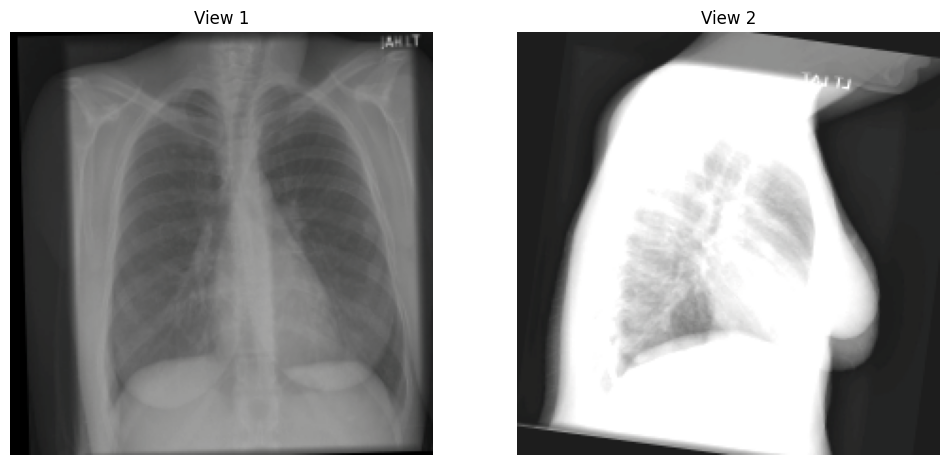


--- Sample Report (Decoded) ---
 normal heart size and mediastinal contours . no focal airspace consolidation . no pleural effusion or pneumothorax . chronic appearing left lateral rib deformities .  1 . no acute cardiopulmonary abnormality . 2 . interval development of healing left sided rib fractures . 
--------------------------------------------------


In [14]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms


# --- Create manifest for multi-view ---
# 5) Build manifest and patient-level split

full_manifest = create_data_manifest(
    XML_REPORTS_PATH,
    IMAGES_PATH,
    tokenizer,
    max_seq_length=MAX_SEQ_LENGTH
)
print(f"Total multi-view studies in manifest: {len(full_manifest)}")

# Unique patients and shuffled split
all_patients = sorted({m['patient_id'] for m in full_manifest})
random.Random(RANDOM_STATE).shuffle(all_patients)

n_patients = len(all_patients)
n_train = int(round(TRAIN_RATIO * n_patients))
n_val   = int(round(VALID_RATIO * n_patients))
n_test  = n_patients - n_train - n_val

train_patients = set(all_patients[:n_train])
val_patients   = set(all_patients[n_train:n_train+n_val])
test_patients  = set(all_patients[n_train+n_val:])

def filter_by_patients(manifest, keep_patients):
    return [m for m in manifest if m['patient_id'] in keep_patients]

train_manifest = filter_by_patients(full_manifest, train_patients)
val_manifest   = filter_by_patients(full_manifest, val_patients)
test_manifest  = filter_by_patients(full_manifest, test_patients)

print("\nData successfully split (patient-level, multi-view, no leakage):")
print(f"Unique patients total: {n_patients}")
print(f"Train patients: {len(train_patients)}, Val patients: {len(val_patients)}, Test patients: {len(test_patients)}")
print(f"Training studies:   {len(train_manifest)}")
print(f"Validation studies: {len(val_manifest)}")
print(f"Test studies:       {len(test_manifest)}")


# --- Create Datasets and DataLoaders for multi-view ---
# 6) Datasets and DataLoaders

train_dataset = IUXRayDataset(train_manifest, tokenizer, train_transform, max_seq_length=MAX_SEQ_LENGTH)
val_dataset   = IUXRayDataset(val_manifest,   tokenizer, val_transform, max_seq_length=MAX_SEQ_LENGTH)
test_dataset  = IUXRayDataset(test_manifest,  tokenizer, val_transform, max_seq_length=MAX_SEQ_LENGTH)

import numpy as np
from torch.utils.data import WeightedRandomSampler

# PREREQUISITE: Make sure you have defined this list of labels somewhere globally
# This must match the order of labels in your manifest's 'chexpert_labels' list.
CHEXPERT_LABELS = [
    'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
    'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
    'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'No Finding'
]

print("\n--- Creating Pathology-Aware Weighted Sampler ---")

# 1. Calculate the prevalence of each pathology in the training set
label_counts = np.sum([item['chexpert_labels'] for item in train_manifest], axis=0)
total_samples = len(train_manifest)
prevalence = label_counts / (total_samples + 1e-8) # Add epsilon for stability

# 2. Calculate a weight for each label (inverse frequency)
label_weights = 1.0 / prevalence
label_weights = np.clip(label_weights, 1.0, 20.0) # Cap weights to prevent extreme values

# 3. For each sample, its weight is the weight of its rarest positive label
sample_weights = []
no_finding_idx = CHEXPERT_LABELS.index('No Finding')

for item in train_manifest:
    labels = np.array(item['chexpert_labels'])
    if labels[no_finding_idx] == 1:
        sample_weights.append(1.0) # Baseline weight for "normal" studies
        continue
    
    positive_label_indices = np.where(labels[:-1] > 0)[0]
    
    if len(positive_label_indices) == 0:
        sample_weights.append(1.0) # Fallback for edge cases
    else:
        rarest_finding_weight = np.max(label_weights[positive_label_indices])
        sample_weights.append(rarest_finding_weight)

# 4. Create the sampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print(f"Sampler created for {len(sample_weights)} training samples.")


train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn,worker_init_fn=_worker_init_fn,
    generator=g,
    persistent_workers=True, pin_memory=True,sampler=sampler,drop_last=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn,worker_init_fn=_worker_init_fn,
    generator=g,
    persistent_workers=True, pin_memory=True,
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=collate_fn,worker_init_fn=_worker_init_fn,
    generator=g,
    persistent_workers=True, pin_memory=True,
)

print("\nPyTorch DataLoaders are ready!")

print("\n--- Verifying a sample batch from the train_loader ---")

# --- Fetch one batch
# 7) Quick sanity check: one batch + visualize views

sample_batch = next(iter(train_loader))
print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['images'].shape}")       # (B,V,3,H,W)
print(f"View mask shape:         {sample_batch['view_mask'].shape}")    # (B,V)
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")    # (B,T)
print(f"Attention mask shape:    {sample_batch['attention_mask'].shape}")
print(f"Labels tensor shape:     {sample_batch['labels'].shape}")
print(f"First study image_paths: {sample_batch['image_paths'][0]}")

# Visualize all (non-padded) views for a random study in the batch
idx_to_show = random.randint(0, sample_batch['images'].size(0) - 1)
images_to_show = sample_batch['images'][idx_to_show]  # (V,3,H,W)
view_mask = sample_batch['view_mask'][idx_to_show]    # (V,)
num_views = images_to_show.size(0)

mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

valid_indices = [i for i in range(num_views) if view_mask[i].item() == 1]
plt.figure(figsize=(6 * len(valid_indices), 6))
for plot_idx, i in enumerate(valid_indices, start=1):
    img_tensor = images_to_show[i]
    img_display = (img_tensor * std) + mean
    img_display = transforms.ToPILImage()(img_display.clamp(0, 1))
    plt.subplot(1, len(valid_indices), plot_idx)
    plt.imshow(img_display)
    plt.title(f"View {i+1}")
    plt.axis('off')
plt.show()

# Decode report for that study
input_ids_display = sample_batch['input_ids'][idx_to_show]
report_display = tokenizer.decode(input_ids_display, skip_special_tokens=True)
print("\n--- Sample Report (Decoded) ---")
print(report_display)
print("-" * 50)



# **MambaVision**

In [15]:
import torch
import torch.nn as nn
from transformers import AutoModel

class MambaVisionEncoder(nn.Module):
    """
    A unified MambaVision class that can be used for multi-label classification
    (for pre-training) or as a powerful feature encoder for report generation.
    """
    def __init__(self, model_name="nvidia/MambaVision-S-1K", num_labels=14, device="cuda", dropout_rate=0.3,
                 for_report_generation=False, trained_classifier_path=None):
        super().__init__()
        self.device = device
        self.for_report_generation = for_report_generation

        # 1. Load the base MambaVision model from Hugging Face
        self.encoder = AutoModel.from_pretrained(
            model_name,
            trust_remote_code=True
        ).to(device)

        # 2. Infer hidden dimension from the model itself
        self.encoder.eval()
        with torch.no_grad():
            dummy = torch.randn(1, 3, 224, 224, device=device)
            pooled_feats, _ = self.encoder(dummy)
            hidden_dim = pooled_feats.shape[-1]

        print(f"Inferred hidden dimension: {hidden_dim}")

        # 3. Define the classification head (only used if for_report_generation is False)
        self.label_head = nn.Sequential(
            nn.Linear(hidden_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_labels)
        ).to(device)

        # 4. Load pre-trained weights if a path is provided (with robust loading)
        if trained_classifier_path:
            print(f"Loading pre-trained classifier weights from: {trained_classifier_path}")
            checkpoint = torch.load(trained_classifier_path, map_location=device)
            # Handle both raw state_dict and checkpoint dictionaries
            if 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            else:
                state_dict = checkpoint
            
            # Handle weights from a compiled model (_orig_mod prefix)
            unwrapped_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
            
            # Use strict=False to gracefully handle loading only encoder weights
            # if the saved model doesn't have the classification head.
            self.load_state_dict(unwrapped_state_dict, strict=False)
            print("Successfully loaded pre-trained weights.")

        # 5. Set initial state
        self.encoder.eval()
        self.frozen = False
        self.freeze() # Start with the encoder frozen by default

    def forward(self, image_tensor):
        """
        Forward pass behavior depends on the 'for_report_generation' flag.
        """
        pooled_feats, features = self.encoder(image_tensor)
        
        if self.for_report_generation:
            # Mode 1: Report Generation - Return patch features
            last_stage_features = features[-1]
            patch_tokens = last_stage_features.flatten(2).permute(0, 2, 1)
            return patch_tokens, features
        else:
            # Mode 2: Classification - Return logits
            logits = self.label_head(pooled_feats)
            return logits, {'pooled': pooled_feats, 'patch': features}

    def freeze(self):
        self.frozen = True
        self.encoder.eval()
        print("Freezing encoder layers.")
        for param in self.encoder.parameters():
            param.requires_grad = False

    def unfreeze(self):
        self.frozen = False
        self.encoder.train()
        print("Unfreezing all encoder layers.")
        for param in self.encoder.parameters():
            param.requires_grad = True

    def unfreeze_encoder_top_layers(self, num_levels_to_unfreeze=1):
        if num_levels_to_unfreeze < 0 or num_levels_to_unfreeze > len(self.encoder.model.levels):
            raise ValueError("num_levels_to_unfreeze must be between 0 and 4.")

        self.freeze()
        if num_levels_to_unfreeze > 0:
            print(f"Unfreezing the last {num_levels_to_unfreeze} encoder level(s)...")
            self.frozen = False
            self.encoder.train()
            for i in range(num_levels_to_unfreeze):
                level_to_unfreeze = self.encoder.model.levels[-(i + 1)]
                for param in level_to_unfreeze.parameters():
                    param.requires_grad = True
        else:
            print("Encoder remains frozen.")

Instantiating model architecture...


config.json: 0.00B [00:00, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/625 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-S-1K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-S-1K:
- modeling_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Inferred hidden dimension: 768
Loading pre-trained classifier weights from: /kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth
Successfully loaded pre-trained weights.
Freezing encoder layers.
Hook registered on: Attention

--- Visualizing 3 samples ---


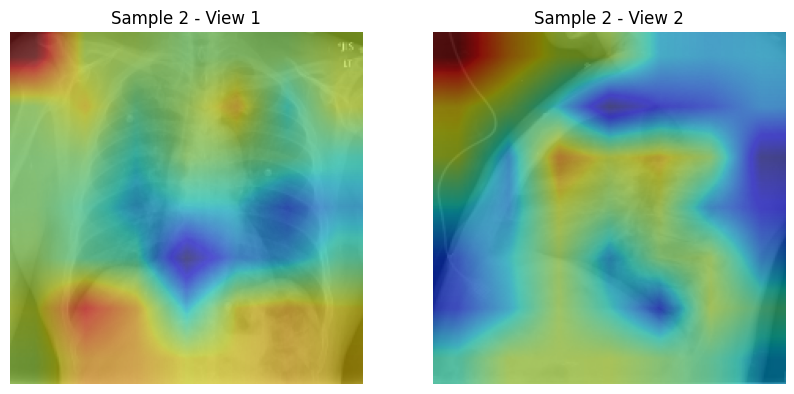

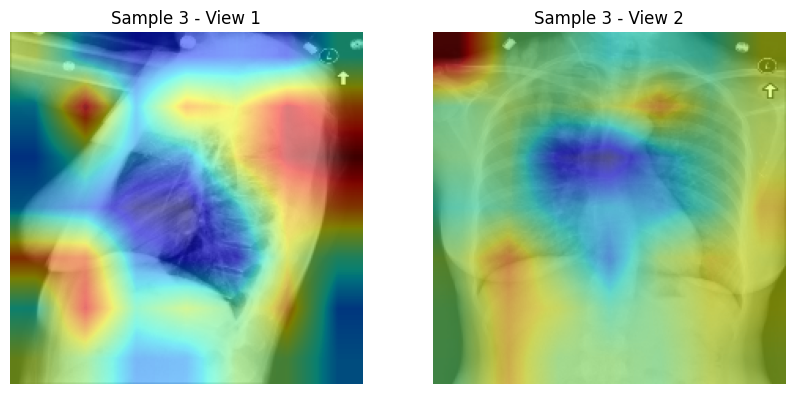

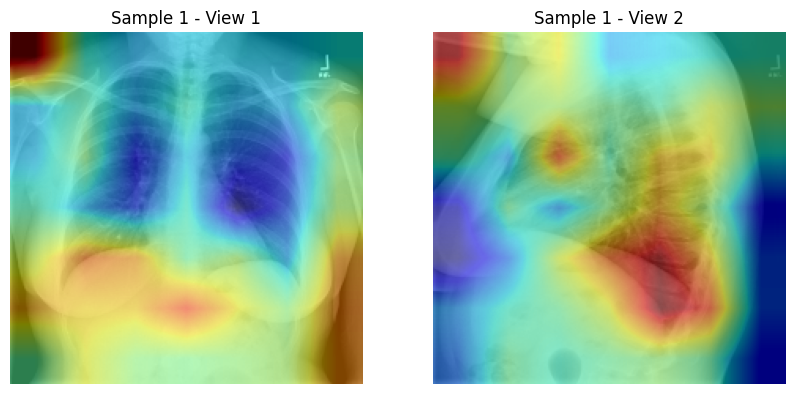


Visualization complete. Hook removed successfully.


In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import random

# --- Global storage ---
final_feature_map = None
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# --- Hook to capture patch features ---
def forward_hook(module, input, output):
    global final_feature_map
    final_feature_map = output.detach()  # [1, N, C]

# --- Load model ---
print("Instantiating model architecture...")
inference_model = MambaVisionEncoder(
    model_name="nvidia/MambaVision-S-1K",
    for_report_generation=False,
    trained_classifier_path="/kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth",
    device=DEVICE
).to(DEVICE)
inference_model.eval()

# --- Register hook on last mixer block ---
target_layer = inference_model.encoder.model.levels[3].blocks[-1].mixer
fwd_hook = target_layer.register_forward_hook(forward_hook)
print(f"Hook registered on: {target_layer.__class__.__name__}")

# --- Mean/Std for denorm ---
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(DEVICE)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(DEVICE)

# --- Visualization loop ---
num_samples_to_show = 3
print(f"\n--- Visualizing {num_samples_to_show} samples ---")

sample_batch = next(iter(test_loader))
images_batch = sample_batch["images"]  # (B, V, 3, H, W)
view_mask = sample_batch.get("view_mask", None)

selected_indices = random.sample(range(images_batch.size(0)), num_samples_to_show)

for idx in selected_indices:
    views = []
    heatmaps = []

    for v in range(images_batch.size(1)):
        if view_mask is not None and view_mask[idx, v] == 0:
            continue

        img_tensor = images_batch[idx, v].unsqueeze(0).to(DEVICE)  # [1,3,H,W]

        # --- Forward pass only ---
        _ = inference_model(img_tensor)  # triggers hook

        # --- Process patch features to 2D heatmap ---
        fmap = final_feature_map[0]  # [N, C]
        N, C = fmap.shape
        h = w = int(np.sqrt(N))
        fmap_2d = fmap.reshape(h, w, C)   # [H, W, C]

        # Convert to heatmap: mean across channels
        heatmap = fmap_2d.mean(axis=2).cpu().numpy()
        heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)  # normalize
        heatmap = F.interpolate(torch.tensor(heatmap).unsqueeze(0).unsqueeze(0),
                                size=(224, 224), mode='bilinear', align_corners=False).squeeze().numpy()

        # Denormalize image for display
        disp_img = (images_batch[idx, v].cpu() * std.cpu() + mean.cpu()).clamp(0, 1)
        pil_img = transforms.ToPILImage()(disp_img)

        views.append(pil_img)
        heatmaps.append(heatmap)

    # --- Plot ---
    num_views = len(views)
    plt.figure(figsize=(5*num_views, 10))
    for i, (orig, hmap) in enumerate(zip(views, heatmaps)):
        plt.subplot(1, num_views, i+1)
        plt.imshow(orig)
        plt.imshow(hmap, cmap='jet', alpha=0.5)  # overlay heatmap
        plt.title(f"Sample {idx} - View {i+1}")
        plt.axis('off')
    plt.show()

# --- Cleanup ---
fwd_hook.remove()
print("\nVisualization complete. Hook removed successfully.")

# **Main Block**

In [17]:
import torch
import torch.nn as nn
from transformers import GPT2Config, GPT2LMHeadModel

# A new wrapper class to use the new fusion module
class VisionLanguageWrapper_CrossAttention(nn.Module):
    def __init__(self, vision_encoder, gpt2_model, vision_dim, text_embed_dim, device='cuda'):
        super().__init__()
        self.vision_encoder = vision_encoder
        self.gpt2 = gpt2_model
        self.device = torch.device(device)
        self.config = gpt2_model.config

        # NEW: A simple linear layer to project vision features to the same
        # dimension as the GPT-2 embeddings. This replaces the old fusion module.
        self.vision_projector = nn.Linear(vision_dim, text_embed_dim)

    def forward(self, images, input_ids, attention_mask=None, labels=None, view_mask=None, chexpert_labels=None):
        B, V, C, H, W = images.shape
        images_flat = images.view(B * V, C, H, W)
    
        # === 1. GET PATCH FEATURES for Report Generation ===
        # Explicitly ensure the encoder is in the correct mode for this task.
        self.vision_encoder.for_report_generation = True
        patch_feats_flat, _ = self.vision_encoder(images_flat)
    
        # Sanity check the output shape to prevent this specific error.
        if patch_feats_flat.dim() != 3:
            raise RuntimeError(
                f"Expected 3D patch features for generation, but got shape {patch_feats_flat.shape}. "
                "This indicates the vision encoder is not in the correct mode."
            )
    
        _, Num_Patches, Vision_Dim = patch_feats_flat.shape
        patch_feats_seq = patch_feats_flat.reshape(B, V * Num_Patches, Vision_Dim)
        encoder_hidden_states = self.vision_projector(patch_feats_seq)
    
        if view_mask is not None:
            encoder_attention_mask = view_mask.unsqueeze(-1).expand(-1, -1, Num_Patches).reshape(B, V * Num_Patches)
        else:
            encoder_attention_mask = torch.ones_like(encoder_hidden_states[:, :, 0])
    
    
        # === 2. GET GENERATION LOSS ===
        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask,
            return_dict=True
        )
        generation_loss = outputs.loss
    
    
        # === 3. GET CLASSIFICATION LOSS (if applicable) ===
        classification_loss = 0.0
        if chexpert_labels is not None:
            # Switch encoder to classification mode. This is simpler and more robust.
            self.vision_encoder.for_report_generation = False
    
            # Get per-image logits directly from the encoder: shape (B*V, num_labels)
            logits_flat, _ = self.vision_encoder(images_flat)
    
            # Reshape to study level: shape (B, V, num_labels)
            logits_study_view = logits_flat.view(B, V, -1)
    
            # Average the logits across the valid views for a final study-level prediction
            if view_mask is not None:
                # Mask out padded views before summing
                logits_study_view = logits_study_view * view_mask.unsqueeze(-1).float()
                study_logits = logits_study_view.sum(dim=1) / view_mask.sum(dim=1).unsqueeze(-1).clamp(min=1)
            else:
                study_logits = logits_study_view.mean(dim=1)
    
            # Calculate the classification loss
            classification_loss = F.binary_cross_entropy_with_logits(
                study_logits,
                chexpert_labels
            )
    
            # IMPORTANT: Switch the encoder back to generation mode for the next batch.
            self.vision_encoder.for_report_generation = True
    
    
        # === 4. COMBINE THE LOSSES ===
        # This lambda is a hyperparameter you can tune. 0.3 is a good starting point.
        lambda_clf = 0.15
        total_loss = generation_loss + (lambda_clf * classification_loss)
    
        # Return a dictionary for easier logging
        return {
            'loss': total_loss,
            'generation_loss': generation_loss,
            'classification_loss': classification_loss,
            'logits': outputs.logits
        }

    # --- Helper methods for freezing/unfreezing and optimizer setup ---
    # (Keep your existing freeze/unfreeze methods: freeze_vision_encoder, etc.)
    # We just need to update the parameter grouping methods.

    def adapter_parameters(self):
        """
        Returns parameters for NEW adapter components: vision projector and
        the cross-attention layers in GPT-2.
        """
        adapter_params = list(self.vision_projector.parameters())
        
        for name, p in self.gpt2.named_parameters():
            if 'crossattention' in name.lower():
                if p.requires_grad:
                    adapter_params.append(p)
        
        return list(set(adapter_params))

    def vision_encoder_parameters(self):
        """Returns all trainable parameters of the vision encoder."""
        return [p for p in self.vision_encoder.parameters() if p.requires_grad]

    def lora_parameters(self):
        """Returns all trainable LoRA parameters."""
        return [p for n, p in self.gpt2.named_parameters() if 'lora' in n and p.requires_grad]
        
    def print_trainable_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable:,} / {total:,}')


    def gpt2_body_parameters(self):
        """
        Returns the main GPT-2 transformer block parameters, EXCLUDING adapters.
        This is necessary to avoid parameter overlap in the optimizer.
        """
        body_params = []
        adapter_param_ids = {id(p) for p in self.adapter_parameters()}
        
        for name, p in self.gpt2.named_parameters():
            if id(p) not in adapter_param_ids and p.requires_grad:
                body_params.append(p)
                
        return body_params

    def vision_encoder_parameters(self):
        """Returns all parameters of the vision encoder."""
        return [p for p in self.vision_encoder.parameters() if p.requires_grad]

    def freeze_decoder_body(self):
        """Freezes all parts of GPT-2 except cross-attention and the LM head."""
        for name, p in self.gpt2.named_parameters():
            if 'crossattention' not in name.lower() and 'lm_head' not in name.lower():
                p.requires_grad = False

In [18]:
from types import SimpleNamespace
from pathlib import Path

# Model-related configuration (for VisionLanguageWrapper and custom GPT-2)
model_config = SimpleNamespace(
    vocab_size = 50_257,         # GPT-2 vocabulary size
    embed_dim = 768,             # Embedding dimension for GPT-2
    num_heads = 12,              # Number of attention heads
    seq_len = 1024,              # Maximum sequence length (tokens)
    depth = 12,                  # Number of transformer layers (blocks)
    attention_dropout = 0.1,     # Dropout for attention layers
    residual_dropout = 0.1,      # Dropout on residual connections
    mlp_ratio = 4,               # FFN hidden size = embed_dim * mlp_ratio
    mlp_dropout = 0.1,           # Dropout for MLP/FFN sublayer
    emb_dropout = 0.1,           # Dropout on embeddings
    vision_dim = 768,            # Output dim of MambaVision encoder's pooled features
    gpt2_emb_dim = 768,          # Input/output dim of GPT-2 embeddings/projection
)



In [19]:
from types import SimpleNamespace
from pathlib import Path

train_config = SimpleNamespace(
    # --- Phase Control ---
    epochs = 65,
    # --- Learning Rates for Different Phases ---
    lr_fusion = 1e-4,    # For fusion module in both phases
    lr_lora = 5e-5,      # For LoRA adapters in both phases
    lr_encoder = 1e-5,   # <-- NEW: VERY LOW LR for the vision encoder in Phase 2

    # --- General Optimizer & Scheduler Settings ---
    device = 'cuda',
    model_path = Path('vl_captioner_staged_v5'),
    batch_size = 8,
    optim = 'AdamW',
    weight_decay = 0.1,
    amsgrad = False,
    lr_scheduler = 'OneCycleLR',
    T_max = 65, # Match total epochs
    eta_min = 1e-7,

    # --- Other Training Settings ---
    grad_accum_steps = 4,
    use_amp = True,
    wandb_project = "vl_captioner",
    wandb_run_name = "staged_v5_full_finetune",
    use_wandb = False,
)

In [20]:
import torch
import torch.nn as nn

def reinitialize_cross_attention_weights(model):
    """
    Properly initializes the weights of NEW cross-attention layers using Kaiming Normal.
    This should be called BEFORE applying PEFT/LoRA.
    """
    print("\n--- Re-initializing cross-attention layers with Kaiming Normal ---")
    
    reinitialized_count = 0
    # Iterate through the transformer blocks of the GPT-2 model
    for layer in model.gpt2.transformer.h:
        # Check if the layer has the cross-attention module
        if hasattr(layer, 'crossattention'):
            # Initialize the main attention projection weights (query, key, value combined)
            nn.init.kaiming_normal_(layer.crossattention.c_attn.weight, mode='fan_in', nonlinearity='relu')
            # Initialize the output projection weights
            nn.init.kaiming_normal_(layer.crossattention.c_proj.weight, mode='fan_in', nonlinearity='relu')
            
            # Initialize biases to zero, which is standard practice
            if layer.crossattention.c_attn.bias is not None:
                nn.init.zeros_(layer.crossattention.c_attn.bias)
            if layer.crossattention.c_proj.bias is not None:
                nn.init.zeros_(layer.crossattention.c_proj.bias)
            
            reinitialized_count += 1
    
    if reinitialized_count > 0:
        print(f"  - Successfully re-initialized {reinitialized_count} cross-attention blocks.")
    else:
        print("  - Warning: No cross-attention blocks were found to re-initialize.")
    print("--- Cross-attention re-initialization complete ---")

In [21]:
# --- FINAL CORRECTED MODEL SETUP ---

from peft import get_peft_model, LoraConfig, TaskType
import warnings

# 1. Initialize Vision Encoder (This is correct)
PRETRAINED_CLASSIFIER_PATH = "/kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth"
vision_encoder = MambaVisionEncoder(
    model_name="nvidia/MambaVision-S-1K",
    for_report_generation=True,
    trained_classifier_path=PRETRAINED_CLASSIFIER_PATH,
    device=train_config.device
).to(train_config.device)

# 2. Initialize GPT-2 with Cross-Attention (This is correct)
print("\nCreating a GPT-2 model configured for cross-attention.")
gpt2_config = GPT2Config.from_pretrained(
    "gpt2",
    add_cross_attention=True,
    vocab_size=len(tokenizer) # Create with the final, correct vocab size
)
gpt2_model = GPT2LMHeadModel(gpt2_config)

# 3. Load Pre-trained Weights (This is correct)
print("Loading pre-trained GPT-2 weights (excluding vocabulary-dependent layers).")
base_gpt2_state_dict = GPT2LMHeadModel.from_pretrained("gpt2").state_dict()
keys_to_ignore = ["lm_head.weight", "transformer.wte.weight"]
filtered_state_dict = {k: v for k, v in base_gpt2_state_dict.items() if k not in keys_to_ignore}

with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    gpt2_model.load_state_dict(filtered_state_dict, strict=False)
print("Successfully loaded weights.")

# --- FIXES APPLIED BELOW ---
# NOTE 1: The redundant `resize_token_embeddings` call has been REMOVED.
# NOTE 2: The premature freezing loop (`for param in ...`) has been REMOVED.
# The Trainer class will now handle freezing/unfreezing correctly.

# 4. Instantiate the Main Vision-Language Model (This is correct)
vl_model = VisionLanguageWrapper_CrossAttention(
    vision_encoder=vision_encoder,
    gpt2_model=gpt2_model,
    vision_dim=model_config.vision_dim,
    text_embed_dim=model_config.gpt2_emb_dim,
    device=train_config.device
).to(train_config.device)

reinitialize_cross_attention_weights(vl_model)

# 5. Apply LoRA (This is correct)
print("\n--- Trainable Parameters (Before LoRA) ---")
vl_model.print_trainable_parameters()

lora_config_advanced = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=["c_attn", "c_proj", "c_fc"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)
vl_model.gpt2 = get_peft_model(vl_model.gpt2, lora_config_advanced)

print("\n--- Trainable Parameters (After LoRA) ---")
vl_model.print_trainable_parameters()

Inferred hidden dimension: 768
Loading pre-trained classifier weights from: /kaggle/input/checkpoint-83-06/best_mamba_multilabel_v2 (1).pth
Successfully loaded pre-trained weights.
Freezing encoder layers.

Creating a GPT-2 model configured for cross-attention.


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Loading pre-trained GPT-2 weights (excluding vocabulary-dependent layers).


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Successfully loaded weights.

--- Re-initializing cross-attention layers with Kaiming Normal ---
  - Successfully re-initialized 12 cross-attention blocks.
--- Cross-attention re-initialization complete ---

--- Trainable Parameters (Before LoRA) ---
Trainable params: 156,107,790 / 206,248,374

--- Trainable Parameters (After LoRA) ---
Trainable params: 7,185,678 / 212,441,526


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [22]:
import torch

def build_optimizer(args, model, verbose=True):
    ve_params = list(model.visual_extractor_parameters())
    ed_params = list(model.decoder_parameters())

    OptimClass = getattr(torch.optim, args.optim)  # e.g., 'AdamW' or 'Adam'
    optim_kwargs = {
        'params': [
            {'params': ve_params, 'lr': args.lr_ve, 'name': 'vision_encoder'},
            {'params': ed_params, 'lr': args.lr_ed, 'name': 'decoder'},
        ],
        'weight_decay': args.weight_decay
    }
    # Only add amsgrad if optimizer supports it
    if args.optim in ['Adam', 'AdamW']:
        optim_kwargs['amsgrad'] = getattr(args, 'amsgrad', False)

    optimizer = OptimClass(**optim_kwargs)

    # Debug print of param group assignments
    if verbose:
        print("\n[Optimizer Setup]")
        for i, pg in enumerate(optimizer.param_groups):
            n_params = sum(p.numel() for p in pg['params'])
            print(f" Group {i}: {pg.get('name','unnamed'):<15} | "
                  f"LR={pg['lr']:.6f} | Params={n_params:,}")

    return optimizer


def build_lr_scheduler(args, optimizer, steps_per_epoch=None, verbose=True):
    SchedClass = getattr(torch.optim.lr_scheduler, args.lr_scheduler)

    if args.lr_scheduler == 'CosineAnnealingLR':
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.T_max, eta_min=args.eta_min)

    elif args.lr_scheduler == 'StepLR':
        scheduler = SchedClass(optimizer, step_size=args.step_size, gamma=args.gamma)

    elif args.lr_scheduler == 'OneCycleLR':
        if steps_per_epoch is None:
            raise ValueError("OneCycleLR requires steps_per_epoch to be provided.")
            
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=[pg['lr'] for pg in optimizer.param_groups], # Uses the LRs you set in the optimizer
            epochs=args.epochs,
            steps_per_epoch=steps_per_epoch,
            pct_start=0.25, # Spend 25% of the time ramping up
            div_factor=10,  # Starting LR will be max_lr / 10
            final_div_factor=1e4 # Final LR will be very small
        )
    else:
        scheduler = SchedClass(optimizer)

    if verbose:
        print(f"\n[Scheduler Setup] Using {args.lr_scheduler}")

    return scheduler

# **Trainer Class**

In [23]:
import os
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import gc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re
from types import SimpleNamespace
import torchvision.transforms as transforms
from transformers import GenerationConfig

try:
    import wandb
except ImportError:
    wandb = None


def _ensure_scalar_loss(loss):
    """Make sure loss is a 0-dim tensor."""
    if isinstance(loss, (tuple, list)):
        loss = loss[0]
    if not torch.is_tensor(loss):
        loss = torch.as_tensor(loss, device='cuda' if torch.cuda.is_available() else 'cpu')
    if loss.dim() > 0:
        loss = loss.mean()
    return loss


class Trainer:
    # `__init__` is indented ONCE (e.g., 4 spaces)
    def __init__(self, vl_model, tokenizer, train_config, dls):
        # The code inside a method is indented TWICE (e.g., 8 spaces)
        self.vl_model = vl_model.to(train_config.device)
        self.tokenizer = tokenizer
        self.train_config = train_config
        self.device = train_config.device
        self.metrics = pd.DataFrame(
            columns=['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity'],
            index=range(train_config.epochs)
        )
        self.train_dl, self.val_dl = dls
        self.scaler = torch.amp.GradScaler(enabled=train_config.use_amp)
        self.grad_accum_steps = train_config.grad_accum_steps
        self.optim = None
        self.lr_scheduler = None

        self.opt_args = SimpleNamespace(
            optim=train_config.optim,
            weight_decay=train_config.weight_decay,
            amsgrad=train_config.amsgrad,
            lr_scheduler=train_config.lr_scheduler,
            epochs=train_config.epochs,
            eta_min=train_config.eta_min,
            T_max=train_config.T_max
        )

    # Each method `def` line must be indented ONCE, at the same level as `__init__`
    def print_optimizer_param_groups(self, epoch):
        rows = []
        for i, g in enumerate(self.optim.param_groups):
            n_params = sum(p.numel() for p in g["params"] if p.requires_grad)
            if n_params == 0: continue
            rows.append({
                "group_name": g.get("name", f"group_{i}"),
                "lr": g["lr"], "weight_decay": g["weight_decay"],
                "n_params": f"{n_params:,}"
            })
        df = pd.DataFrame(rows)
        print(f"\n=== Optimizer Param Groups (Epoch {epoch+1}) ===")
        print(df.to_string(index=False))

    def save_model(self):
        self.train_config.model_path.mkdir(exist_ok=True, parents=True)
        torch.save(self.vl_model.state_dict(), self.train_config.model_path / 'vl_model.pt')
        print(f"Model saved to {self.train_config.model_path / 'vl_model.pt'}")

    def load_best_model(self):
        model_path = self.train_config.model_path / 'vl_model.pt'
        print(f"Loading best model from {model_path}")
        sd = torch.load(model_path, map_location=self.device)
        self.vl_model.load_state_dict(sd)

    def load_best_model_from_path(self,path):
        model_path = path
        print(f"Loading best model from {model_path}")
        sd = torch.load(model_path, map_location=self.device)
        self.vl_model.load_state_dict(sd)

# In your Trainer class

    def train_one_epoch(self, epoch):
        self.vl_model.train()
        running_loss = 0.0
        self.optim.zero_grad(set_to_none=True)
        progress_bar = tqdm(self.train_dl, desc=f"Epoch {epoch+1} Training")
    
        for step, batch in enumerate(progress_bar):
            # --- 1. Move data to device ---
            images = batch['images'].to(self.device, non_blocking=True)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None:
                view_mask = view_mask.to(self.device, non_blocking=True)
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            labels = batch['labels'].clone().to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
            
            # <<< FIX: Extract CheXpert labels from the batch and move to device >>>
            chexpert_labels = batch['chexpert_labels'].to(self.device, non_blocking=True)
    
            # --- 2. Forward pass with Automatic Mixed Precision ---
            with torch.amp.autocast(self.device, enabled=self.train_config.use_amp):
                outputs = self.vl_model(
                    images=images,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    view_mask=view_mask,
                    chexpert_labels=chexpert_labels # <-- Now this will work
                )
                loss = outputs['loss']
                gen_loss = outputs['generation_loss'].item() # Assumes your model returns a dict
                clf_loss = outputs['classification_loss'].item() # Assumes your model returns a dict
    
            if not torch.isfinite(loss):
                raise RuntimeError(f"FATAL: Non-finite loss ({loss.item()}) detected. Training stopped.")
    
            loss_to_backprop = loss / self.grad_accum_steps
            self.scaler.scale(loss_to_backprop).backward()
    
            if (step + 1) % self.grad_accum_steps == 0:
                self.scaler.unscale_(self.optim)
                torch.nn.utils.clip_grad_norm_(self.vl_model.parameters(), max_norm=1.0)
                self.scaler.step(self.optim)
                self.scaler.update()
                self.optim.zero_grad(set_to_none=True)
                if self.lr_scheduler and isinstance(self.lr_scheduler, torch.optim.lr_scheduler.OneCycleLR):
                    self.lr_scheduler.step()
    
            running_loss += loss.item()
            current_lr = self.optim.param_groups[0]['lr']
            # Update postfix to show all losses
            progress_bar.set_postfix(loss=loss.item(), gen_loss=gen_loss, clf_loss=clf_loss, lr=f"{current_lr:.6f}")
        
        train_loss = running_loss / len(self.train_dl)
        train_pxp = np.exp(train_loss)
        self.metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)
        print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Perplexity {train_pxp:.4f}")
        
        return train_loss

# In your Trainer class

    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        self.vl_model.eval()
        running_loss = 0.0
        progress_bar = tqdm(self.val_dl, desc=f"Epoch {epoch+1} Validation")
        for batch in progress_bar:
            images = batch['images'].to(self.device, non_blocking=True)
            view_mask = batch.get('view_mask', None)
            if view_mask is not None: view_mask = view_mask.to(self.device, non_blocking=True)
            input_ids = batch['input_ids'].to(self.device, non_blocking=True)
            labels = batch['labels'].clone().to(self.device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)
            
            # <<< FIX: Extract CheXpert labels from the batch and move to device >>>
            chexpert_labels = batch['chexpert_labels'].to(self.device, non_blocking=True)
    
            with torch.amp.autocast(self.device, enabled=self.train_config.use_amp):
                outputs = self.vl_model(
                    images=images,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    view_mask=view_mask,
                    chexpert_labels=chexpert_labels # <-- Now this will work
                )
                loss = outputs['loss']
    
            running_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())
            
        val_loss = running_loss / len(self.val_dl)
        val_pxp = np.exp(val_loss)
        self.metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)
        print(f"Epoch {epoch+1}: Val Loss {val_loss:.4f}, Perplexity {val_pxp:.4f}")
        
        return val_loss

    def clean(self):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()



    def fit(self):
        best_loss = float('inf')
        best_epoch = -1
        patience = 7 # Or your preferred patience for early stopping
        epochs_since_improvement = 0
        self.train_config.model_path.mkdir(exist_ok=True, parents=True)
    
        # =================================================================
        # UNIFIED SETUP (DONE ONCE, BEFORE THE LOOP)
        # =================================================================
        print("\n--- Setting up model and optimizer for co-adaptation training ---")
        
        # --- 1. Set the model's training state from the start ---
        # Unfreeze the vision encoder's top layers immediately so it can adapt from epoch 1.
        self.vl_model.vision_encoder.unfreeze_encoder_top_layers(num_levels_to_unfreeze=2)
    
        # Set requires_grad for the trainable parts of the decoder.
        for name, param in self.vl_model.gpt2.named_parameters():
            is_trainable = 'lora' in name or \
                           'crossattention' in name or \
                           'wte' in name or \
                           'lm_head' in name
            param.requires_grad_(is_trainable)
    
        # --- 2. Define parameter groups with differential learning rates ---
        encoder_params = self.vl_model.vision_encoder_parameters()
        lora_params = self.vl_model.lora_parameters()
        adapter_params = self.vl_model.adapter_parameters()
        vocab_params = [p for n, p in self.vl_model.gpt2.named_parameters() if ('wte' in n or 'lm_head' in n) and p.requires_grad]
    
        # Ensure parameter groups are mutually exclusive (your correct fix)
        lora_param_ids = {id(p) for p in lora_params}
        adapter_params = [p for p in adapter_params if id(p) not in lora_param_ids]
        vocab_params = [p for p in vocab_params if id(p) not in lora_param_ids]
    
        # This is the core of the strategy: different LRs for different components.
        param_groups = [
            # The vision encoder learns very slowly and carefully.
            {'params': encoder_params, 'lr': self.train_config.lr_encoder, 'name': 'vision_encoder'},
            
            # The new/adapter layers learn quickly.
            {'params': adapter_params, 'lr': self.train_config.lr_fusion, 'name': 'adapters'},
            {'params': lora_params, 'lr': self.train_config.lr_lora, 'name': 'lora_modules'},
            {'params': vocab_params, 'lr': self.train_config.lr_fusion, 'name': 'vocab_layers'}
        ]
        
        # --- 3. Create the optimizer and scheduler once ---
        self.optim = torch.optim.AdamW(param_groups, weight_decay=self.train_config.weight_decay)
        
        steps_per_epoch = len(self.train_dl)
        print(f"Calculated steps_per_epoch for scheduler: {steps_per_epoch}")
        self.lr_scheduler = build_lr_scheduler(self.opt_args, self.optim, steps_per_epoch=steps_per_epoch)
    
        # =================================================================
        # UNIFIED TRAINING LOOP
        # =================================================================
        for epoch in range(self.train_config.epochs):
            print(f"\n{'='*25} Epoch {epoch + 1}/{self.train_config.epochs} {'='*25}")
            
            # The setup logic is no longer inside the loop.
            self.vl_model.print_trainable_parameters()
            self.print_optimizer_param_groups(epoch)
            
            # --- The rest of the loop is exactly as it was before ---
            train_loss = self.train_one_epoch(epoch)
            self.clean()
            val_loss = self.valid_one_epoch(epoch)
            self.clean()
            
            # OneCycleLR is stepped inside train_one_epoch. This handles other schedulers.
            # if self.lr_scheduler:
            #     if not isinstance(self.lr_scheduler, torch.optim.lr_scheduler.OneCycleLR):
            #         self.lr_scheduler.step()
    
            if val_loss < best_loss:
                print(f"** Validation loss improved: {best_loss:.4f} -> {val_loss:.4f} (Epoch {epoch+1}) **")
                best_loss, best_epoch = val_loss, epoch
                self.save_model()
                epochs_since_improvement = 0
            else:
                epochs_since_improvement += 1
                print(f"No improvement for {epochs_since_improvement} epochs.")
    
            if epochs_since_improvement >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement.")
                break
    
        print(f'\nTraining complete. Best validation loss: {best_loss:.4f} at epoch {best_epoch + 1}.')
        self.load_best_model()
        return {'best_val_loss': best_loss, 'best_epoch': best_epoch}

    def plot_loss_and_perplexity(self):
        if self.metrics.empty:
            print("No metrics available to plot yet.")
            return
    
        # Drop rows where metrics might not have been recorded (e.g., if training was interrupted)
        plottable_metrics = self.metrics.dropna()
        if plottable_metrics.empty:
            print("Metrics dataframe is empty after dropping NaNs. Cannot plot.")
            return
            
        epochs = plottable_metrics.index + 1
    
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot Loss
        axes[0].plot(epochs, plottable_metrics['train_loss'], label='Train Loss', marker='o')
        axes[0].plot(epochs, plottable_metrics['val_loss'], label='Val Loss', marker='o')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training and Validation Loss')
        axes[0].legend()
        axes[0].grid(True)
        
        # Plot Perplexity (log scale)
        axes[1].plot(epochs, plottable_metrics['train_perplexity'], label='Train Perplexity', marker='o')
        axes[1].plot(epochs, plottable_metrics['val_perplexity'], label='Val Perplexity', marker='o')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Perplexity')
        axes[1].set_yscale('log')
        axes[1].set_title('Training and Validation Perplexity (log scale)')
        axes[1].legend()
        axes[1].grid(True)
    
        plt.tight_layout()
        plt.show()

    @torch.no_grad()
    def clean_and_format_report(self, generated_report: str) -> str:
        rep = generated_report.replace('<SECTION_FINDINGS>', '\nFindings:').replace('<SECTION_IMPRESSION>', '\nImpression:')
        patterns = {k: re.compile(rf'{k}:(.*?)((?=\n[a-zA-Z]+:)|$)', re.DOTALL) for k in ['Findings', 'Impression']}
        sections = {k: (patterns[k].search(rep).group(1).strip() if patterns[k].search(rep) else "") for k in patterns}
        for k in sections:
            lines, seen = [], set()
            for line in re.split(r'(?<=\.)\s+', sections[k]):
                if line and line not in seen:
                    lines.append(line)
                    seen.add(line)
            sections[k] = " ".join(lines).strip()
        return f"Findings: {sections['Findings']}"



    @torch.no_grad()
    def generate_report(self, image_input, generation_config=None, show_image=False):
        """
        Generates a radiology report using the cross-attention model.
        """
        self.vl_model.eval()
    
        # --- 1. Image Preprocessing (no changes) ---
        if not isinstance(image_input, list): image_input = [image_input]
        pil_imgs = [Image.open(p).convert('RGB') if isinstance(p, (str, os.PathLike)) else p.convert('RGB') for p in image_input]
        if show_image:
            # ... your plotting code ...
            pass
        transform = val_transform # Use validation transform
        images = torch.stack([transform(image=np.array(img))['image'] for img in pil_imgs]).unsqueeze(0).to(self.device)
    
        # --- 2. Compute Visual Features for Cross-Attention (MODIFIED) ---
        B, V, C, H, W = images.shape
        images_flat = images.view(B * V, C, H, W)
        patch_feats_flat, _ = self.vl_model.vision_encoder(images_flat)
        _, Num_Patches, _ = patch_feats_flat.shape
        patch_feats_seq = patch_feats_flat.reshape(B, V * Num_Patches, -1)
        
        # Project features to become encoder_hidden_states
        encoder_hidden_states = self.vl_model.vision_projector(patch_feats_seq)
        # Create the corresponding mask
        encoder_attention_mask = torch.ones(encoder_hidden_states.shape[:2], device=self.device, dtype=torch.long)
    
        # --- 3. Prepare Text Inputs (SIMPLIFIED) ---
        # We only need the starting token. No prefix, no manual embedding.
        start_token_id = self.tokenizer.convert_tokens_to_ids("<SECTION_FINDINGS>")
        input_ids = torch.tensor([[start_token_id]], device=self.device)
    
        # --- 4. Define Generation Configuration (no changes) ---
        if generation_config is None:
            generation_config = GenerationConfig(
                max_new_tokens=350, num_beams=2, repetition_penalty=1.2,
                eos_token_id=self.tokenizer.eos_token_id,
                pad_token_id=self.tokenizer.pad_token_id,
            )
    
        # --- 5. Generate Text (MODIFIED) ---
        # The .generate method is smart. We just need to pass it the visual context.
        generated_ids = self.vl_model.gpt2.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask
        )
    
        # --- 6. Decode and Clean (no changes) ---
        output_ids = generated_ids[0][1:] # Slice to remove the prompt token
        generated_text = self.tokenizer.decode(output_ids, skip_special_tokens=True)
        full_generated_text = "<SECTION_FINDINGS> " + generated_text
        return self.clean_and_format_report(full_generated_text)

    @torch.no_grad()
    def generate_report_v2(self, image_input, generation_config=None, show_image=False):
        """
        Generates a radiology report using SAMPLING-based decoding (top-k, top-p).
        This often produces more diverse and natural-sounding text than beam search.
        """
        self.vl_model.eval()
    
        # --- 1. Image Preprocessing (No changes) ---
        if not isinstance(image_input, list): image_input = [image_input]
        pil_imgs = [Image.open(p).convert('RGB') if isinstance(p, (str, os.PathLike)) else p.convert('RGB') for p in image_input]
        if show_image:
            # (Your plotting code would go here)
            fig, axes = plt.subplots(1, len(pil_imgs), figsize=(6 * len(pil_imgs), 6))
            if len(pil_imgs) == 1: axes = [axes]
            for ax, img in zip(axes, pil_imgs):
                ax.imshow(img)
                ax.axis('off')
            plt.show()
            
        transform = val_transform # Use the same validation transform
        images = torch.stack([transform(image=np.array(img))['image'] for img in pil_imgs]).unsqueeze(0).to(self.device)
    
        # --- 2. Compute Visual Features for Cross-Attention (No changes) ---
        B, V, C, H, W = images.shape
        images_flat = images.view(B * V, C, H, W)
        self.vl_model.vision_encoder.for_report_generation = True
        patch_feats_flat, _ = self.vl_model.vision_encoder(images_flat)
        _, Num_Patches, _ = patch_feats_flat.shape
        patch_feats_seq = patch_feats_flat.reshape(B, V * Num_Patches, -1)
        
        encoder_hidden_states = self.vl_model.vision_projector(patch_feats_seq)
        encoder_attention_mask = torch.ones(encoder_hidden_states.shape[:2], device=self.device, dtype=torch.long)
    
        # --- 3. Prepare Text Inputs (No changes) ---
        start_token_id = self.tokenizer.convert_tokens_to_ids("<SECTION_FINDINGS>")
        input_ids = torch.tensor([[start_token_id]], device=self.device)
    
        # --- 4. Define Generation Configuration (THE CORE CHANGE) ---
        if generation_config is None:
            # This is the new configuration for sampling-based decoding.
            generation_config = GenerationConfig(
                max_new_tokens=350,
                
                # --- Sampling Parameters ---
                do_sample=True,      # The master switch to enable sampling
                temperature=0.7,     # Controls randomness. Lower (<1.0) makes it less random.
                top_k=50,            # Considers only the top 50 most likely words at each step.
                top_p=0.95,          # Nucleus sampling: considers the smallest set of words with a cumulative probability of 95%.
                
                # --- Other Essential Parameters ---
                num_beams=1,         # CRITICAL: Must be 1 when using do_sample=True
                repetition_penalty=1.2,
                eos_token_id=self.tokenizer.eos_token_id,
                pad_token_id=self.tokenizer.pad_token_id,
            )
    
        # --- 5. Generate Text (No change in the function call) ---
        generated_ids = self.vl_model.gpt2.generate(
            input_ids=input_ids,
            generation_config=generation_config,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_attention_mask
        )
    
        # --- 6. Decode and Clean (No changes) ---
        # The prompt token is the first one, so we slice it off.
        output_ids = generated_ids[0][1:]
        generated_text = self.tokenizer.decode(output_ids, skip_special_tokens=True)
        full_generated_text = "<SECTION_FINDINGS> " + generated_text
        return self.clean_and_format_report(full_generated_text)

In [24]:
trainer = Trainer(
    vl_model,
    tokenizer,
    train_config,
    (train_loader, val_loader)
)


In [25]:
trainer.load_best_model_from_path("/kaggle/input/iu-wtd-cr-attn-final-model-weights/vl_model.pt")

Loading best model from /kaggle/input/iu-wtd-cr-attn-final-model-weights/vl_model.pt


In [26]:
# trainer.fit() 

# **Loading Trained Model**

In [27]:
# trainer.load_best_model()

# **Report Genearation**

In [28]:
# from transformers import GenerationConfig

# # Configuration 1: Balanced Sampling
# generation_config_sampling = GenerationConfig(
#     max_new_tokens=350,
#     do_sample=True,
#     temperature=0.7,   # Lower temperature -> less random; higher -> more random
#     top_k=50,          # Considers the 50 most likely tokens at each step
#     top_p=0.95,        # Nucleus sampling
#     num_beams=1,       # Must be 1 for sampling
#     repetition_penalty=1.2,
#     eos_token_id=tokenizer.eos_token_id,
#     pad_token_id=tokenizer.pad_token_id,
# )

# # Configuration 2: More Creative Sampling (higher temperature)
# generation_config_creative = GenerationConfig(
#     max_new_tokens=350,
#     do_sample=True,
#     temperature=0.9,
#     top_k=50,
#     top_p=0.95,
#     num_beams=1,
#     repetition_penalty=1.2,
#     eos_token_id=tokenizer.eos_token_id,
#     pad_token_id=tokenizer.pad_token_id,
# )

# generation_config_beam = GenerationConfig(
#     max_new_tokens=350,
#     num_beams=4,  # Increased from 2 to 4
#     repetition_penalty=1.2,
#     eos_token_id=tokenizer.eos_token_id,
#     pad_token_id=tokenizer.pad_token_id,
# )

# generation_config_refined = GenerationConfig(
#     max_new_tokens=350,
    
#     # --- The Core Settings ---
#     do_sample=True,
#     temperature=0.8,    # <-- SLIGHTLY REDUCED from 0.9. This is the key change to reduce nonsense.
#     top_k=50,           # <-- Keep this. It prevents the model from picking truly bizarre, low-probability words.
#     top_p=0.95,         # <-- Keep this. Nucleus sampling is very effective.
    
#     # --- Other Parameters ---
#     num_beams=1,
#     repetition_penalty=1.2,
#     eos_token_id=tokenizer.eos_token_id,
#     pad_token_id=tokenizer.pad_token_id,
# )

# generation_config_clinical = GenerationConfig(
#     max_new_tokens=350,
    
#     # --- The Core Settings for More Confident Sampling ---
#     do_sample=True,
#     temperature=0.8,     # Slightly higher temp encourages more diversity and less conservative word choices.
#     top_k=50,            # Keeps it from picking truly bizarre words.
#     top_p=0.9,           # Slightly lower top_p can force it to consider less probable (but potentially correct) words.
    
#     # --- Other Parameters ---
#     num_beams=1,         # Must be 1 for sampling.
#     repetition_penalty=1.2,
#     eos_token_id=tokenizer.eos_token_id,
#     pad_token_id=tokenizer.pad_token_id,
# )

In [29]:
from transformers import GenerationConfig

# Configuration 1: Balanced Sampling (v1)
generation_config_sampling = GenerationConfig(
    max_new_tokens=350, do_sample=True, temperature=0.7,
    top_k=50, top_p=0.95, num_beams=1, repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
)

# Configuration 2: More Creative Sampling (v2)
generation_config_creative = GenerationConfig(
    max_new_tokens=350, do_sample=True, temperature=0.9,
    top_k=50, top_p=0.95, num_beams=1, repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
)

# Configuration 3: Standard Beam Search (v3)
generation_config_beam = GenerationConfig(
    max_new_tokens=350, num_beams=4, repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
)

# Configuration 4: Refined Sampling (v4)
generation_config_refined = GenerationConfig(
    max_new_tokens=350, do_sample=True, temperature=0.8,
    top_k=50, top_p=0.95, num_beams=1, repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
)

# Configuration 5: Your Primary Clinical Sampling Config
generation_config_clinical = GenerationConfig(
    max_new_tokens=350, do_sample=True, temperature=0.8,
    top_k=50, top_p=0.9, num_beams=1, repetition_penalty=1.2,
    eos_token_id=tokenizer.eos_token_id, pad_token_id=tokenizer.pad_token_id,
)

# Create a dictionary to hold all configs for the ablation study
configs_to_evaluate = {
    "Balanced Sampling (v1)": generation_config_sampling,
    "Creative Sampling (v2)": generation_config_creative,
    "Beam Search (v3)": generation_config_beam,
    "Refined Sampling (v4)": generation_config_refined,
    "Clinical Sampling (v5)": generation_config_clinical,
}

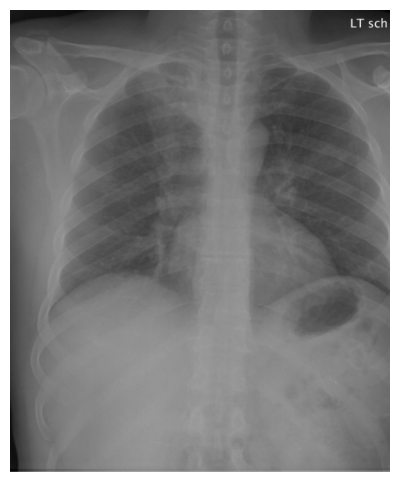

`generation_config` default values have been modified to match model-specific defaults: {'bos_token_id': 50256}. If this is not desired, please set these values explicitly.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Generated report (beam):
 Findings: the heart size is normal in size . no focal airspace consolidation , pleural effusions or pneumothoraces . aorta upper limits of hilar contours without pulmonary edema . no pneumothorax . vague opacity consistent with left lower lobe nodule may represent further assess . 2 . otherwise unremarkable x- to appropriate comparison films study may exclude reoplas it may be helpful . recommend followup evaluate series weeks to resolution for further infectious process .


In [30]:
report_beam = trainer.generate_report_v2(
    image_input=["/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1000_IM-0003-1001.png"],
    show_image=True,
    generation_config=generation_config_clinical,
)

print("Generated report (beam):\n", report_beam)

In [31]:
import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

from torch.utils.data import DataLoader
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from rouge_score import rouge_scorer
from tqdm import tqdm
import pandas as pd
import numpy as np

def run_ablation_on_configs(dataloader, trainer, tokenizer, configs_dict, device, max_samples=None):
    """
    Runs an ablation study over multiple generation configurations.
    
    (Docstring remains the same)
    """
    summary_results = []
    smooth = SmoothingFunction()
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    for config_name, config_object in configs_dict.items():
        print(f"\n--- Evaluating with configuration: {config_name} ---")
        
        results_per_config = []
        sample_count = 0

        for batch in tqdm(dataloader, desc=f"Evaluating {config_name}"):
            # ... (code to get reference_text and pil_imgs is the same) ...
            input_ids = batch['input_ids']
            image_paths_list = batch['image_paths']

            for i in range(len(image_paths_list)):
                if max_samples and sample_count >= max_samples:
                    break

                gt_input_ids = input_ids[i]
                if tokenizer.pad_token_id is not None:
                    gt_input_ids = gt_input_ids[gt_input_ids != tokenizer.pad_token_id]
                reference_text = tokenizer.decode(gt_input_ids, skip_special_tokens=True)
                
                if not isinstance(reference_text, str) or len(reference_text.strip()) == 0:
                    continue

                pil_imgs = [Image.open(p).convert('RGB') for p in image_paths_list[i]]
                
                gen_report = trainer.generate_report_v2(
                    pil_imgs,
                    generation_config=config_object,
                )
                
                # Tokenize for metrics
                ref_tokens = word_tokenize(reference_text.lower())
                hyp_tokens = word_tokenize(gen_report.lower())

                if not hyp_tokens: continue

                # Calculate BLEU scores
                bleu1 = sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth.method1)
                bleu2 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth.method1)
                bleu3 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth.method1)
                bleu4 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth.method1)

                # <<< FIX: Pass the TOKENIZED versions to meteor_score >>>
                meteor = single_meteor_score(ref_tokens, hyp_tokens)

                # ROUGE-L is calculated on raw strings, so this is correct
                rouge_l_score = rouge.score(reference_text, gen_report)['rougeL'].fmeasure

                results_per_config.append({
                    'BLEU-1': bleu1, 'BLEU-2': bleu2, 'BLEU-3': bleu3, 'BLEU-4': bleu4,
                    'METEOR': meteor, 'ROUGE-L': rouge_l_score
                })
                
                sample_count += 1
            if max_samples and sample_count >= max_samples:
                break
        
        # Calculate and store the average scores for this configuration
        if results_per_config:
            temp_df = pd.DataFrame(results_per_config)
            avg_scores = temp_df.mean().to_dict()
            avg_scores['config_name'] = config_name
            summary_results.append(avg_scores)

    final_df = pd.DataFrame(summary_results).set_index('config_name')
    return final_df

In [32]:

ablation_results_df = run_ablation_on_configs(
    dataloader=test_loader,
    trainer=trainer,
    tokenizer=tokenizer,
    configs_dict=configs_to_evaluate,
    device=train_config.device,
    # max_samples=100 # Optional: for quick testing
)

# Print the final, beautiful comparison table
print("\n--- Ablation Study on Decoding Strategies ---")
print(ablation_results_df.round(4)) # Round for cleaner display


--- Evaluating with configuration: Balanced Sampling (v1) ---


Evaluating Balanced Sampling (v1): 100%|██████████| 96/96 [28:11<00:00, 17.62s/it]



--- Evaluating with configuration: Creative Sampling (v2) ---


Evaluating Creative Sampling (v2): 100%|██████████| 96/96 [32:55<00:00, 20.57s/it]



--- Evaluating with configuration: Beam Search (v3) ---


Evaluating Beam Search (v3): 100%|██████████| 96/96 [30:05<00:00, 18.81s/it]



--- Evaluating with configuration: Refined Sampling (v4) ---


Evaluating Refined Sampling (v4): 100%|██████████| 96/96 [30:29<00:00, 19.06s/it]



--- Evaluating with configuration: Clinical Sampling (v5) ---


Evaluating Clinical Sampling (v5): 100%|██████████| 96/96 [29:42<00:00, 18.57s/it]


--- Ablation Study on Decoding Strategies ---
                        BLEU-1  BLEU-2  BLEU-3  BLEU-4  METEOR  ROUGE-L
config_name                                                            
Balanced Sampling (v1)  0.3475  0.2065  0.1313  0.0825  0.3534   0.2552
Creative Sampling (v2)  0.3156  0.1810  0.1105  0.0653  0.3315   0.2219
Beam Search (v3)        0.3594  0.2182  0.1466  0.0975  0.3536   0.2806
Refined Sampling (v4)   0.3363  0.1929  0.1179  0.0720  0.3397   0.2404
Clinical Sampling (v5)  0.3384  0.2021  0.1275  0.0778  0.3493   0.2453


In [33]:

ablation_results_df = run_ablation_on_configs(
    dataloader=val_loader,
    trainer=trainer,
    tokenizer=tokenizer,
    configs_dict=configs_to_evaluate,
    device=train_config.device,
    # max_samples=100 # Optional: for quick testing
)

# Print the final, beautiful comparison table
print("\n--- Ablation Study on Decoding Strategies ---")
print(ablation_results_df.round(4)) # Round for cleaner display


--- Evaluating with configuration: Balanced Sampling (v1) ---


Evaluating Balanced Sampling (v1): 100%|██████████| 96/96 [29:41<00:00, 18.56s/it]



--- Evaluating with configuration: Creative Sampling (v2) ---


Evaluating Creative Sampling (v2): 100%|██████████| 96/96 [34:10<00:00, 21.35s/it]



--- Evaluating with configuration: Beam Search (v3) ---


Evaluating Beam Search (v3): 100%|██████████| 96/96 [29:54<00:00, 18.69s/it]



--- Evaluating with configuration: Refined Sampling (v4) ---


Evaluating Refined Sampling (v4): 100%|██████████| 96/96 [30:48<00:00, 19.26s/it]



--- Evaluating with configuration: Clinical Sampling (v5) ---


Evaluating Clinical Sampling (v5): 100%|██████████| 96/96 [30:25<00:00, 19.01s/it]


--- Ablation Study on Decoding Strategies ---
                        BLEU-1  BLEU-2  BLEU-3  BLEU-4  METEOR  ROUGE-L
config_name                                                            
Balanced Sampling (v1)  0.3402  0.1995  0.1246  0.0749  0.3377   0.2459
Creative Sampling (v2)  0.3175  0.1781  0.1061  0.0622  0.3199   0.2203
Beam Search (v3)        0.3518  0.2136  0.1426  0.0940  0.3428   0.2736
Refined Sampling (v4)   0.3292  0.1945  0.1222  0.0754  0.3350   0.2425
Clinical Sampling (v5)  0.3439  0.1996  0.1232  0.0756  0.3392   0.2433


# **Clinical accuracy**

In [34]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import numpy as np

# --- 1. Your Label Extraction Logic (Copied from your code) ---
#    (No changes needed here, just make sure it's defined)

CHEXPERT_LABELS = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion",
    "Edema", "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax",
    "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices", "No Finding"
]

PATTERNS = {
    "Cardiomegaly": [r"cardiomegaly", r"enlarged heart"],
    "Pleural Effusion": [r"pleural effusion", r"fluid in the pleura"],
    "Atelectasis": [r"atelectasis", r"lung collapse"],
    "Pneumonia": [r"pneumonia", r"infected lung"],
    "Edema": [r"pulmonary edema", r"lung edema"],
    "Pneumothorax": [r"pneumothorax", r"collapsed lung"],
    "Fracture": [r"fracture", r"broken rib"],
    "Consolidation": [r"consolidation"],
    "Lung Opacity": [r"opacity"],
}

NEGATIONS = [r"\bno\b", r"without", r"absent", r"negative for"]
UNCERTAINTY = [r"possible", r"suspicious for", r"cannot rule out", r"likely"]

def extract_labels(report: str):
    report = report.lower()
    # Initialize all labels to 0 (negative)
    labels = {label: 0 for label in CHEXPERT_LABELS}
    any_positive = False
    
    # We only care about positive findings for this evaluation
    # so we will treat "uncertain" (-1) as negative (0).
    for label, patterns in PATTERNS.items():
        for pat in patterns:
            for match in re.finditer(pat, report):
                # Simple context check for negation
                start = max(0, match.start() - 25)
                context = report[start:match.start()]
                if not any(re.search(n, context) for n in NEGATIONS):
                    labels[label] = 1
                    any_positive = True
                    break # Move to the next label once a positive is found
            if labels[label] == 1:
                break
    
    labels["No Finding"] = 1 if not any_positive else 0
    return labels

# --- 2. The New Evaluation Function ---

def evaluate_clinical_accuracy(dataloader, trainer, tokenizer, generation_config, label_extractor, device, max_samples=None):
    """
    Evaluates the clinical accuracy of generated reports using a rule-based label extractor.
    
    Args:
        dataloader: The DataLoader for the evaluation dataset.
        trainer: The trained Trainer object.
        tokenizer: The tokenizer.
        generation_config: The specific GenerationConfig to use for creating reports.
        label_extractor: The function (e.g., your `extract_labels`) that takes a string
                         report and returns a dictionary of labels.
        device: The device to run on.
        max_samples: (Optional) The maximum number of samples to evaluate.
        
    Returns:
        A string containing the scikit-learn classification report.
        A DataFrame with the raw labels for further analysis.
    """
    all_gt_labels = []
    all_pred_labels = []
    
    sample_count = 0
    for batch in tqdm(dataloader, desc="Evaluating Clinical Accuracy"):
        gt_labels_batch = batch['chexpert_labels']
        image_paths_list = batch['image_paths']

        for i in range(len(image_paths_list)):
            if max_samples and sample_count >= max_samples:
                break
            
            # A. Get Ground Truth Labels from the dataloader
            # We only care about positive (1) vs not-positive (0) for this comparison
            gt_labels_vector = (gt_labels_batch[i].numpy() > 0).astype(int)
            
            # B. Generate the report
            pil_imgs = [Image.open(p).convert('RGB') for p in image_paths_list[i]]
            generated_report = trainer.generate_report_v2(
                pil_imgs,
                generation_config=generation_config
            )

            # C. Extract Predicted Labels from the generated report using the same logic
            pred_labels_dict = label_extractor(generated_report)
            pred_labels_vector = np.array([pred_labels_dict[label] for label in CHEXPERT_LABELS])
            
            all_gt_labels.append(gt_labels_vector)
            all_pred_labels.append(pred_labels_vector)
            sample_count += 1
        
        if max_samples and sample_count >= max_samples:
            break
            
    # Convert lists to numpy arrays for scikit-learn
    all_gt_labels = np.array(all_gt_labels)
    all_pred_labels = np.array(all_pred_labels)
    
    # D. Calculate and return the report
    report = classification_report(
        all_gt_labels,
        all_pred_labels,
        target_names=CHEXPERT_LABELS,
        zero_division=0
    )
    
    # Also create a DataFrame for detailed inspection if needed
    labels_df = pd.DataFrame({
        'gt': list(all_gt_labels),
        'pred': list(all_pred_labels)
    })
    
    return report, labels_df



In [35]:
print("\n--- Evaluating Clinical Accuracy using 'Clinical Sampling (v5)' ---")
clinical_report, detailed_labels_df = evaluate_clinical_accuracy(
    dataloader=val_loader,
    trainer=trainer,
    tokenizer=tokenizer,
    generation_config=generation_config_clinical, # Use your best config
    label_extractor=extract_labels,
    device=train_config.device,
    #max_samples=10 # Optional for quick test
)

# Print the final report
print("\n--- Clinical Accuracy Report ---")
print(clinical_report)

# You can also inspect the detailed DataFrame
# print("\n--- Detailed Label Comparison (first 5) ---")
# print(detailed_labels_df.head())


--- Evaluating Clinical Accuracy using 'Clinical Sampling (v5)' ---


Evaluating Clinical Accuracy: 100%|██████████| 96/96 [29:20<00:00, 18.34s/it]


--- Clinical Accuracy Report ---
                            precision    recall  f1-score   support

Enlarged Cardiomediastinum       0.00      0.00      0.00         0
              Cardiomegaly       0.31      0.58      0.41        24
              Lung Opacity       0.05      0.13      0.08        23
               Lung Lesion       0.00      0.00      0.00         0
                     Edema       0.00      0.00      0.00        20
             Consolidation       0.00      0.00      0.00        24
                 Pneumonia       0.07      0.21      0.10        14
               Atelectasis       0.35      0.28      0.31        47
              Pneumothorax       0.36      0.59      0.45       122
          Pleural Effusion       0.22      0.52      0.31        91
             Pleural Other       0.00      0.00      0.00         0
                  Fracture       0.08      0.28      0.12        18
           Support Devices       0.00      0.00      0.00         0
             

In [36]:
print("\n--- Evaluating Clinical Accuracy using 'Clinical Sampling (v5)' ---")
clinical_report, detailed_labels_df = evaluate_clinical_accuracy(
    dataloader=test_loader,
    trainer=trainer,
    tokenizer=tokenizer,
    generation_config=generation_config_clinical, # Use your best config
    label_extractor=extract_labels,
    device=train_config.device,
    #max_samples=10 # Optional for quick test
)

# Print the final report
print("\n--- Clinical Accuracy Report ---")
print(clinical_report)



--- Evaluating Clinical Accuracy using 'Clinical Sampling (v5)' ---


Evaluating Clinical Accuracy: 100%|██████████| 96/96 [29:53<00:00, 18.68s/it]


--- Clinical Accuracy Report ---
                            precision    recall  f1-score   support

Enlarged Cardiomediastinum       0.00      0.00      0.00         0
              Cardiomegaly       0.24      0.38      0.29        24
              Lung Opacity       0.15      0.30      0.20        27
               Lung Lesion       0.00      0.00      0.00         0
                     Edema       0.00      0.00      0.00        18
             Consolidation       0.00      0.00      0.00        31
                 Pneumonia       0.11      0.29      0.16        24
               Atelectasis       0.32      0.36      0.34        33
              Pneumothorax       0.37      0.51      0.43       144
          Pleural Effusion       0.25      0.46      0.32       109
             Pleural Other       0.00      0.00      0.00         0
                  Fracture       0.07      0.26      0.12        19
           Support Devices       0.00      0.00      0.00         0
             

In [37]:
# import matplotlib.pyplot as plt
# import torchvision.transforms as transforms
# import torch
# import random

# def evaluate_on_val_samples(trainer, val_loader, tokenizer, num_samples=5):
#     mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
#     std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

#     # Get a single batch from val_loader
#     sample_batch = next(iter(val_loader))
#     images_batch = sample_batch['images']  # (batch, max_views, 3, H, W)
#     input_ids = sample_batch['input_ids']
#     image_paths_batch = sample_batch['image_paths']  # list of lists

#     total_samples = min(num_samples, images_batch.size(0))
#     selected_indices = random.sample(range(images_batch.size(0)), total_samples)

#     for idx in selected_indices:
#         images_tensor_list = []
#         pil_imgs = []
#         # Visualize all views per sample, skip padded views if a view_mask exists
#         if 'view_mask' in sample_batch:
#             view_mask = sample_batch['view_mask'][idx]  # (max_views,)
#         else:
#             view_mask = [1] * images_batch.size(1)
#         for view_idx in range(images_batch.size(1)):
#             if view_mask[view_idx] == 0:
#                 continue  # skip padded images
#             image_tensor = images_batch[idx, view_idx].cpu()
#             image_disp = (image_tensor * std) + mean
#             image_disp = torch.clamp(image_disp, 0, 1)
#             pil_img = transforms.ToPILImage()(image_disp)
#             pil_imgs.append(pil_img)
#             images_tensor_list.append(image_tensor)

#         # Plot all views in a row
#         num_views = len(pil_imgs)
#         plt.figure(figsize=(5 * num_views, 5))
#         for i, img in enumerate(pil_imgs):
#             plt.subplot(1, num_views, i+1)
#             plt.imshow(img)
#             plt.title(f"View {i+1}")
#             plt.axis('off')
#         plt.show()

#         # Decode ground truth report
#         ground_truth_ids = input_ids[idx]
#         ground_truth_report = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

#         # Generate report from all views using robust_generate_radiology_report
#         generated_report = trainer.generate_report_v2(
#             image_input=pil_imgs,
#             generation_config=generation_config_sampling,
        
#         )
#         generated_report_v2 = trainer.generate_report_v2(
#             image_input=pil_imgs,
#             generation_config=generation_config_creative,
        
#         )
#         generated_report_v3 = trainer.generate_report_v2(
#             image_input=pil_imgs,
#             generation_config=generation_config_beam,
        
#         )
#         generated_report_v4 = trainer.generate_report_v2(
#             image_input=pil_imgs,
#             generation_config=generation_config_refined,
        
#         )
#         generated_report_v5 = trainer.generate_report_v2(
#             image_input=pil_imgs,
#             generation_config=generation_config_clinical,
        
#         )


#         print(f"\n--- Ground Truth Report ---\n{ground_truth_report.strip()}")
#         print(f"\n--- Generated Report-generation_config_sampling ---\n{generated_report.strip()}")
#         print(f"\n--- Generated Report_v2-generation_config_creative ---\n{generated_report_v2.strip()}")
#         print(f"\n--- Generated Report_v3 -generation_config_beam---\n{generated_report_v3.strip()}")
#         print(f"\n--- Generated Report_v4 -generation_config_refined---\n{generated_report_v4.strip()}")
#         print(f"\n--- Generated Report_v5 -generation_config_clinical---\n{generated_report_v5.strip()}")
#         print("-" * 80)

In [38]:
# evaluate_on_val_samples(trainer, test_loader, tokenizer, num_samples=5)

In [39]:
# trainer.plot_loss_and_perplexity()